In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [5]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst.append(dataset_utilizer(**dictlis[i]))
        dfall.append(inst[i].dfall)
        df.append(inst[i].df)
        dfpred.append(inst[i].dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['aveadsE/suratom'] >= -2.0]

In [7]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

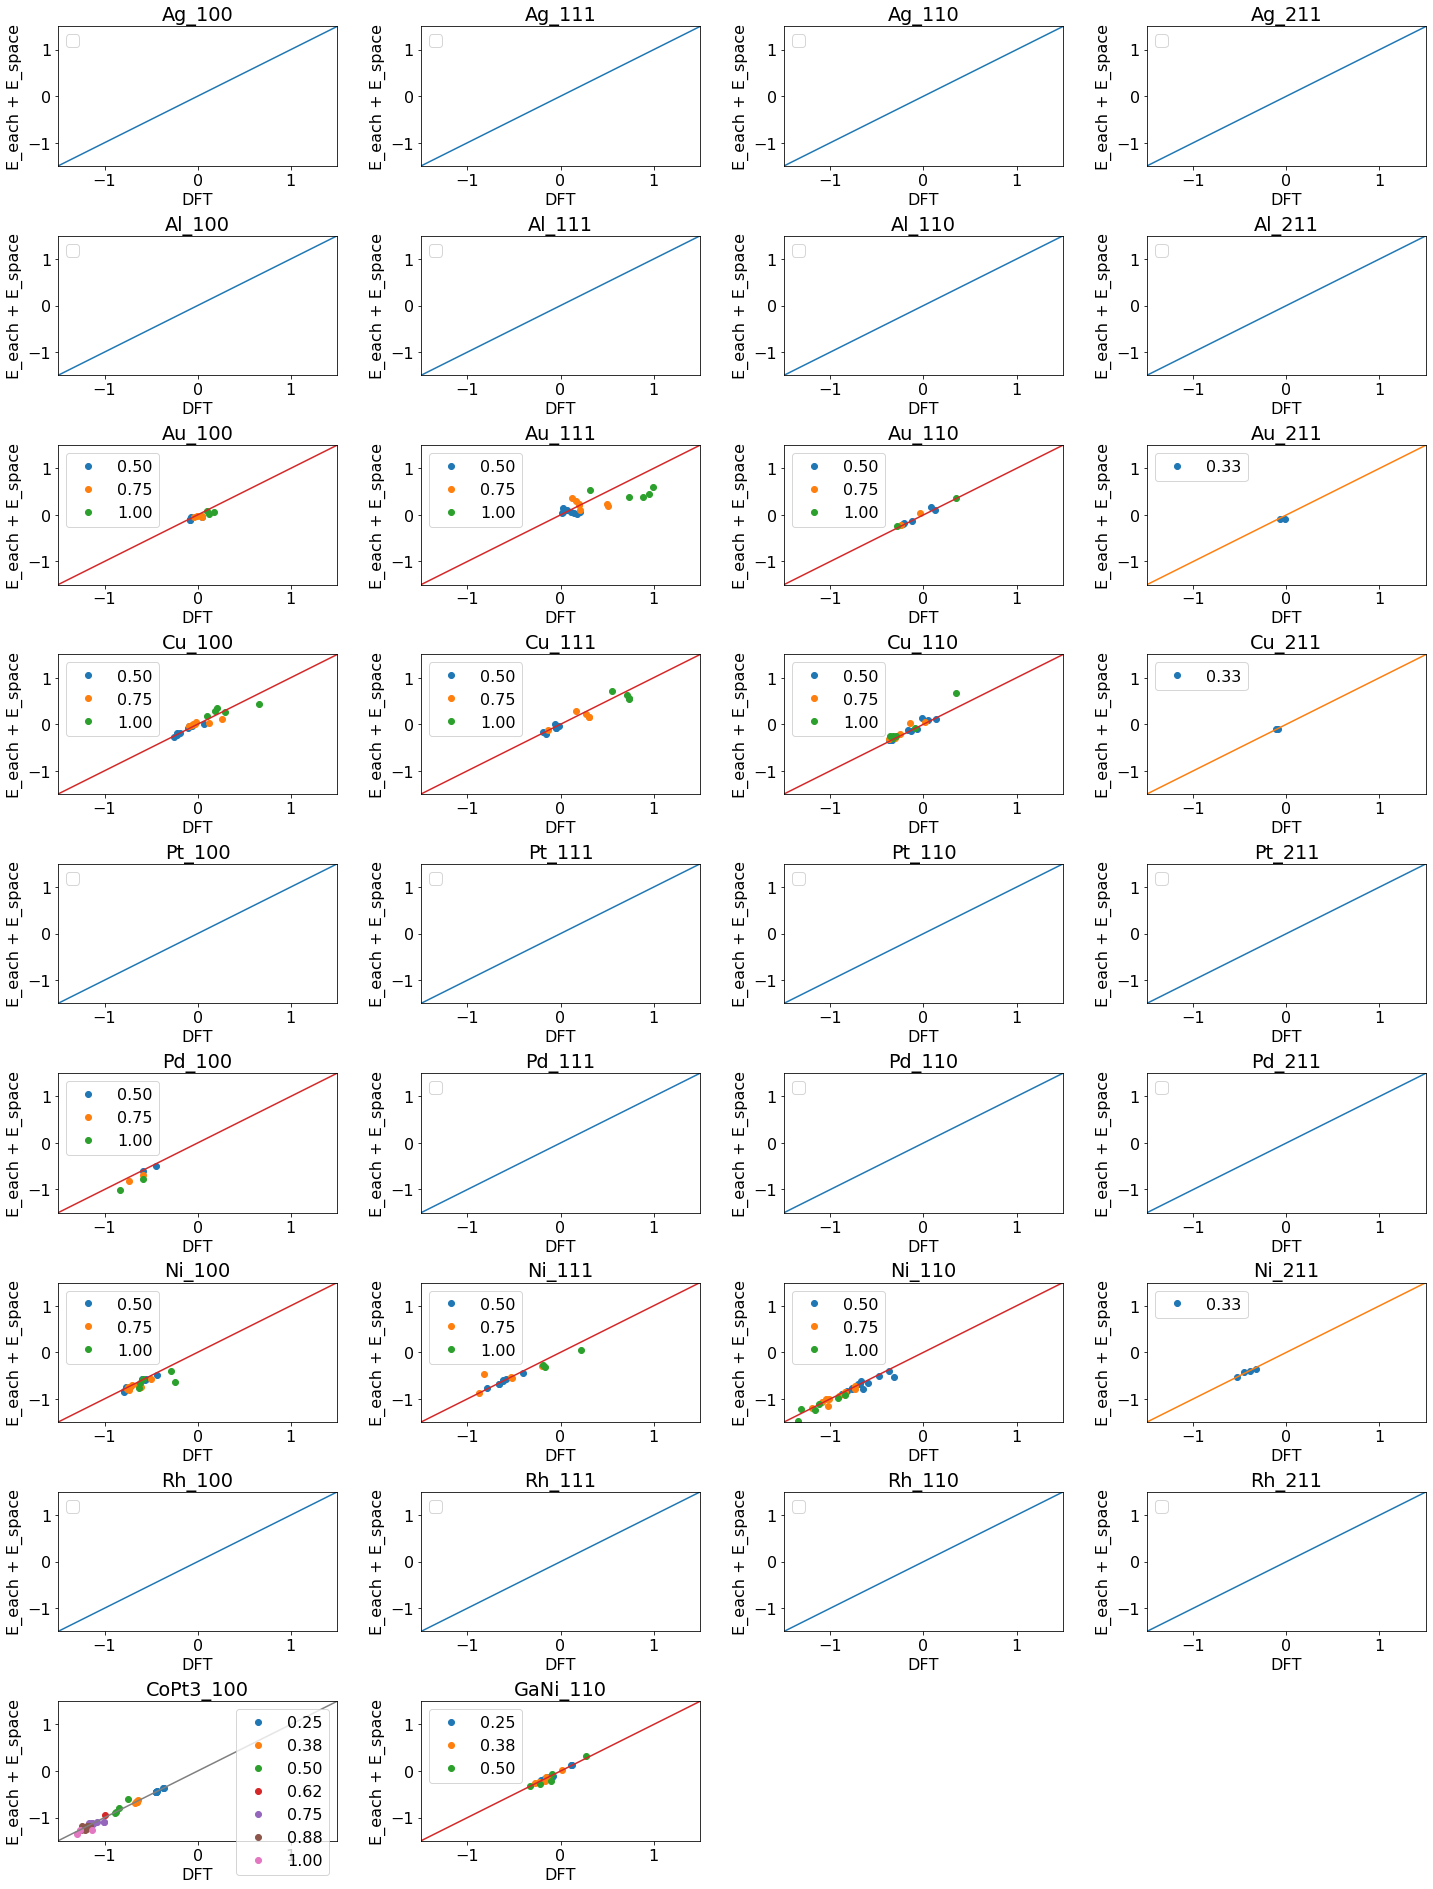

In [8]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

In [9]:
dfall[11]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e75073ff215505f6e704466,Au_211_u2_RPBE_no001_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.294757,-59.804108,-14.485436,-0.005212,-0.000869,-0.005212,0.002501,NaN,NaN,43.15572,0.023172,[0],[0],yes,no,yes,yes,NaN,NaN,NaN
1,5e75073ff215505f6e704468,Au_211_u2_RPBE_no002_CO_n1_d9.traj,yes,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.655231,-59.804108,-14.485436,-0.365686,-0.060948,-0.365686,0.002501,NaN,NaN,43.15572,0.023172,[1],[1],yes,yes,yes,yes,NaN,NaN,NaN
2,5e750740f215505f6e70446a,Au_211_u2_RPBE_no002_CO_n2_d3.traj,yes,yes,Au,211,2,RPBE,CO,2,0.333333,6,-89.213444,-59.804108,-14.485436,-0.438463,-0.073077,-0.219232,0.249920,-0.731373,0.007165,43.15572,0.046344,"[1, 1]","[1, 1]",yes,yes,yes,yes,3.0,0.0,0.571429
3,5e750747f215505f6e70446c,Au_211_u2_RPBE_no003_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.638502,-59.804108,-14.485436,-0.348957,-0.058159,-0.348957,0.002717,NaN,NaN,43.15572,0.023172,[2],[1],no,yes,no,yes,NaN,NaN,NaN
4,5e750748f215505f6e70446e,Au_211_u2_RPBE_no004_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.297233,-59.804108,-14.485436,-0.007689,-0.001281,-0.007689,0.002501,NaN,NaN,43.15572,0.023172,[3],[7],yes,no,no,yes,NaN,NaN,NaN
5,5e750748f215505f6e704470,Au_211_u2_RPBE_no004_CO_n2_d3.traj,yes,yes,Au,211,2,RPBE,CO,2,0.333333,6,-88.878251,-59.804108,-14.485436,-0.103270,-0.017212,-0.051635,0.249921,-0.792505,0.073219,43.15572,0.046344,"[5, 5]","[5, 5]",yes,yes,yes,yes,2.0,1.0,0.142857
6,5e750765f215505f6e704472,Au_211_u2_RPBE_no005_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.285915,-59.804108,-14.485436,0.003629,0.000605,0.003629,0.002717,NaN,NaN,43.15572,0.023172,[4],[4],yes,no,yes,yes,NaN,NaN,NaN
7,5e750765f215505f6e704474,Au_211_u2_RPBE_no006_CO_n1_d9.traj,yes,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.685797,-59.804108,-14.485436,-0.396252,-0.066042,-0.396252,0.002501,NaN,NaN,43.15572,0.023172,[5],[5],yes,yes,yes,yes,NaN,NaN,NaN
8,5e750766f215505f6e704476,Au_211_u2_RPBE_no007_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.636592,-59.804108,-14.485436,-0.347047,-0.057841,-0.347047,0.002501,NaN,NaN,43.15572,0.023172,[6],[1],yes,yes,no,yes,NaN,NaN,NaN
9,5e750766f215505f6e704478,Au_211_u2_RPBE_no008_CO_n1_d9.traj,no,No,Au,211,2,RPBE,CO,1,0.166667,6,-74.308346,-59.804108,-14.485436,-0.018801,-0.003134,-0.018801,0.002501,NaN,NaN,43.15572,0.023172,[7],[7],yes,no,yes,yes,NaN,NaN,NaN


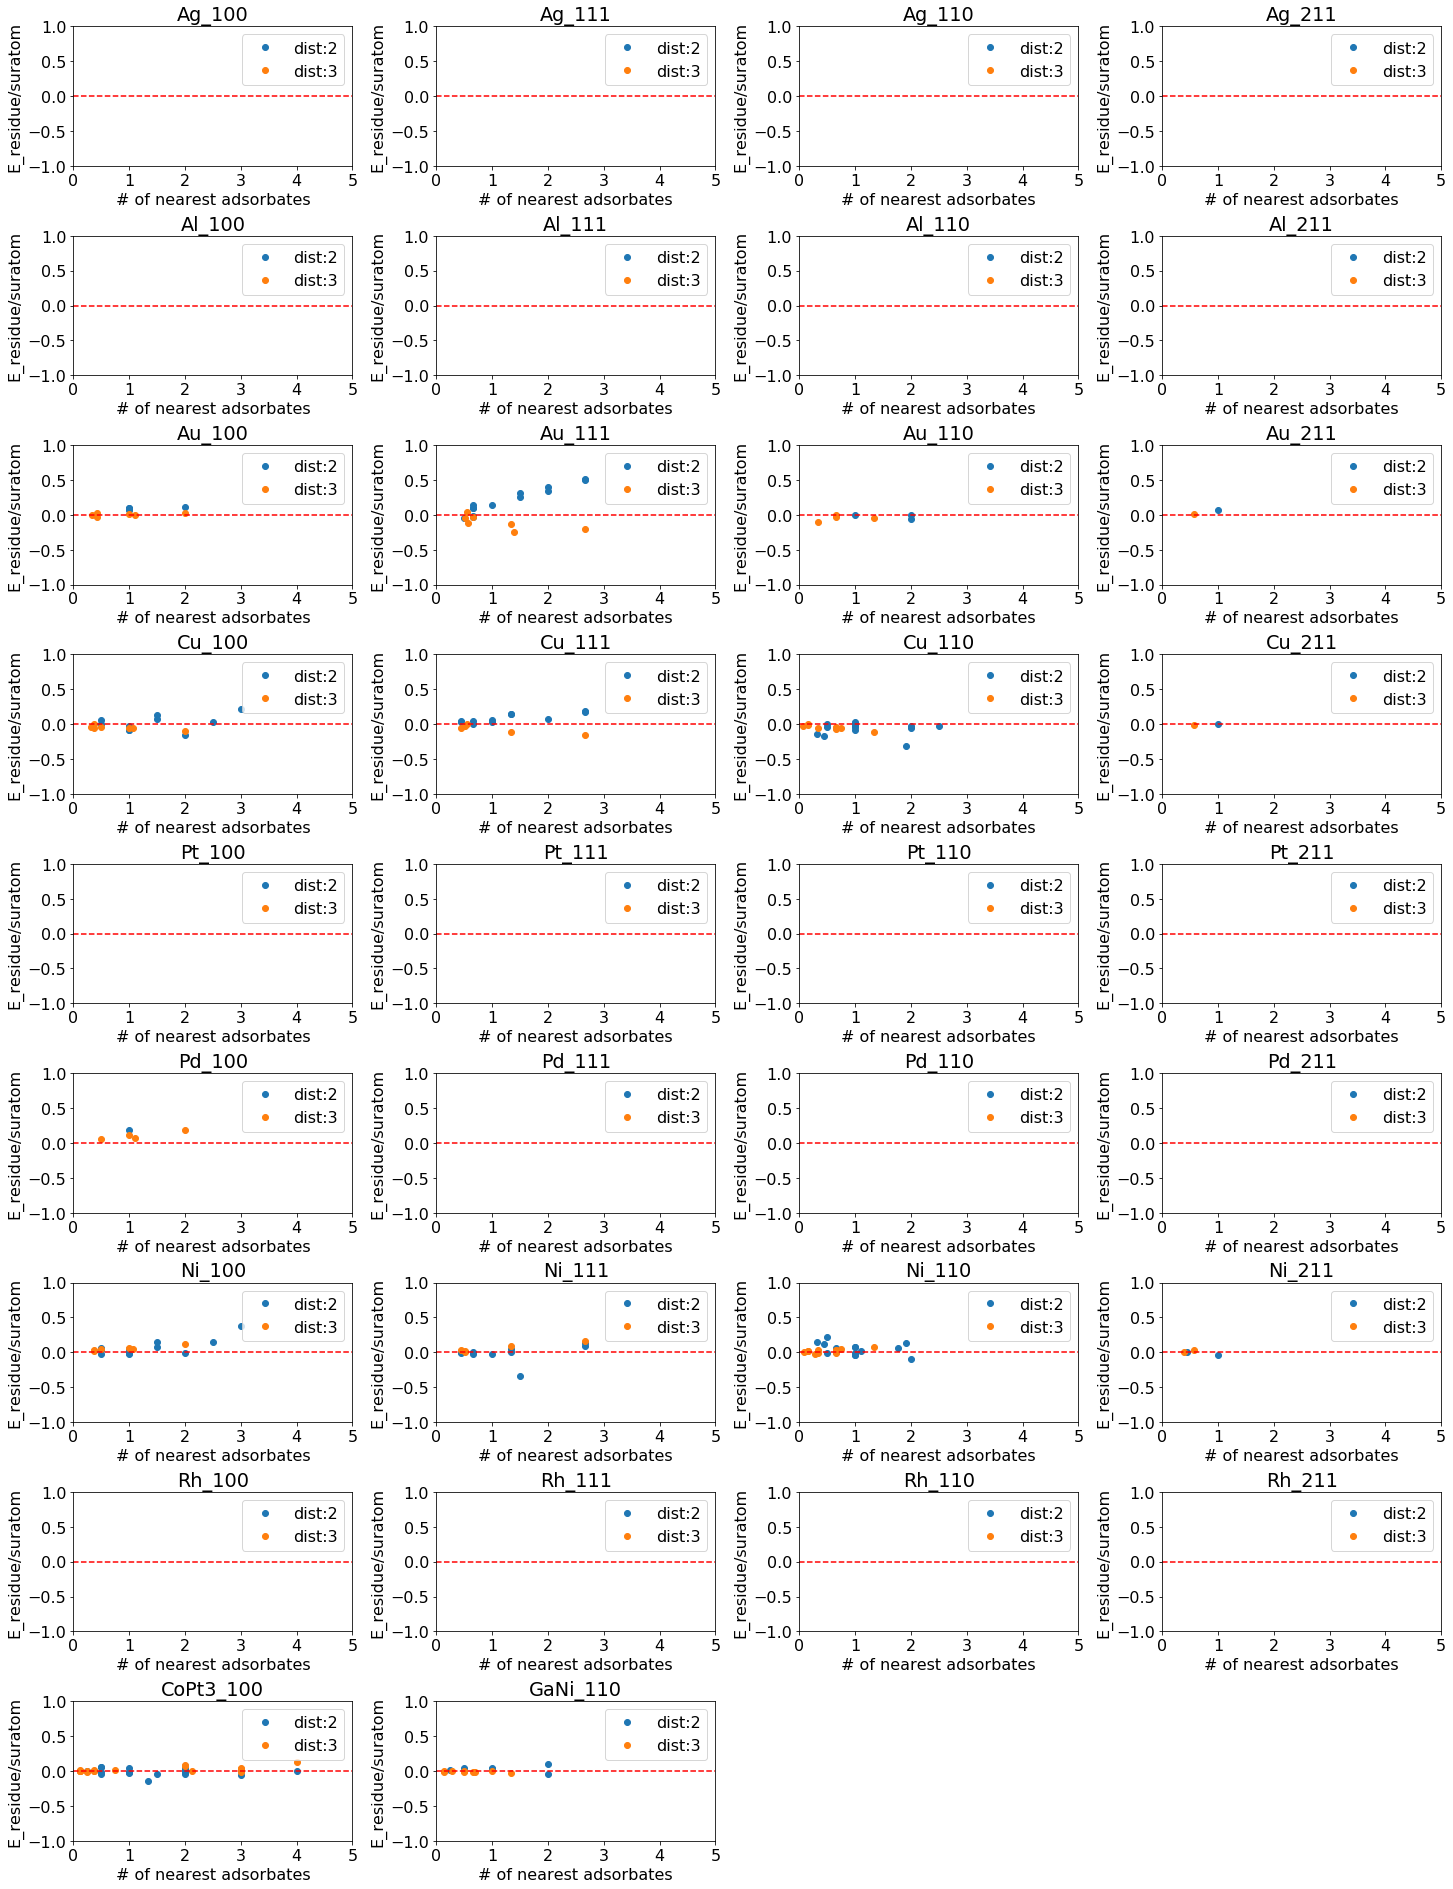

In [10]:
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

5
[0.06548956] [0.01083368]
5
[0.06548956] [0.01083368]
5
[0.06548956] [0.01083368]
13
[0.23316675] [-0.09418942]
13
[0.23316675] [-0.09418942]
13
[0.23316675] [-0.09418942]
3
[-0.0050292] [-0.03574962]
3
[-0.0050292] [-0.03574962]
3
[-0.0050292] [-0.03574962]
1
[0.07142772] [0.01253859]
12
[0.03758396] [-0.05291369]
12
[0.03758396] [-0.05291369]
12
[0.03758396] [-0.05291369]
11
[0.09811103] [-0.06365112]
11
[0.09811103] [-0.06365112]
11
[0.09811103] [-0.06365112]
14
[-0.02514964] [-0.08262249]
14
[-0.02514964] [-0.08262249]
14
[-0.02514964] [-0.08262249]
1
[0.011058] [-0.01716257]
1
[0.0335765] [0.09424938]
1
[0.0335765] [0.09424938]
1
[0.0335765] [0.09424938]
13
[0.04157906] [0.05981675]
13
[0.04157906] [0.05981675]
13
[0.04157906] [0.05981675]
10
[-0.01827546] [0.06227296]
10
[-0.01827546] [0.06227296]
10
[-0.01827546] [0.06227296]
16
[0.00889565] [0.04415957]
16
[0.00889565] [0.04415957]
16
[0.00889565] [0.04415957]
2
[-0.03832226] [0.03585451]
22
[-0.01861888] [0.01834788]
22
[-0.

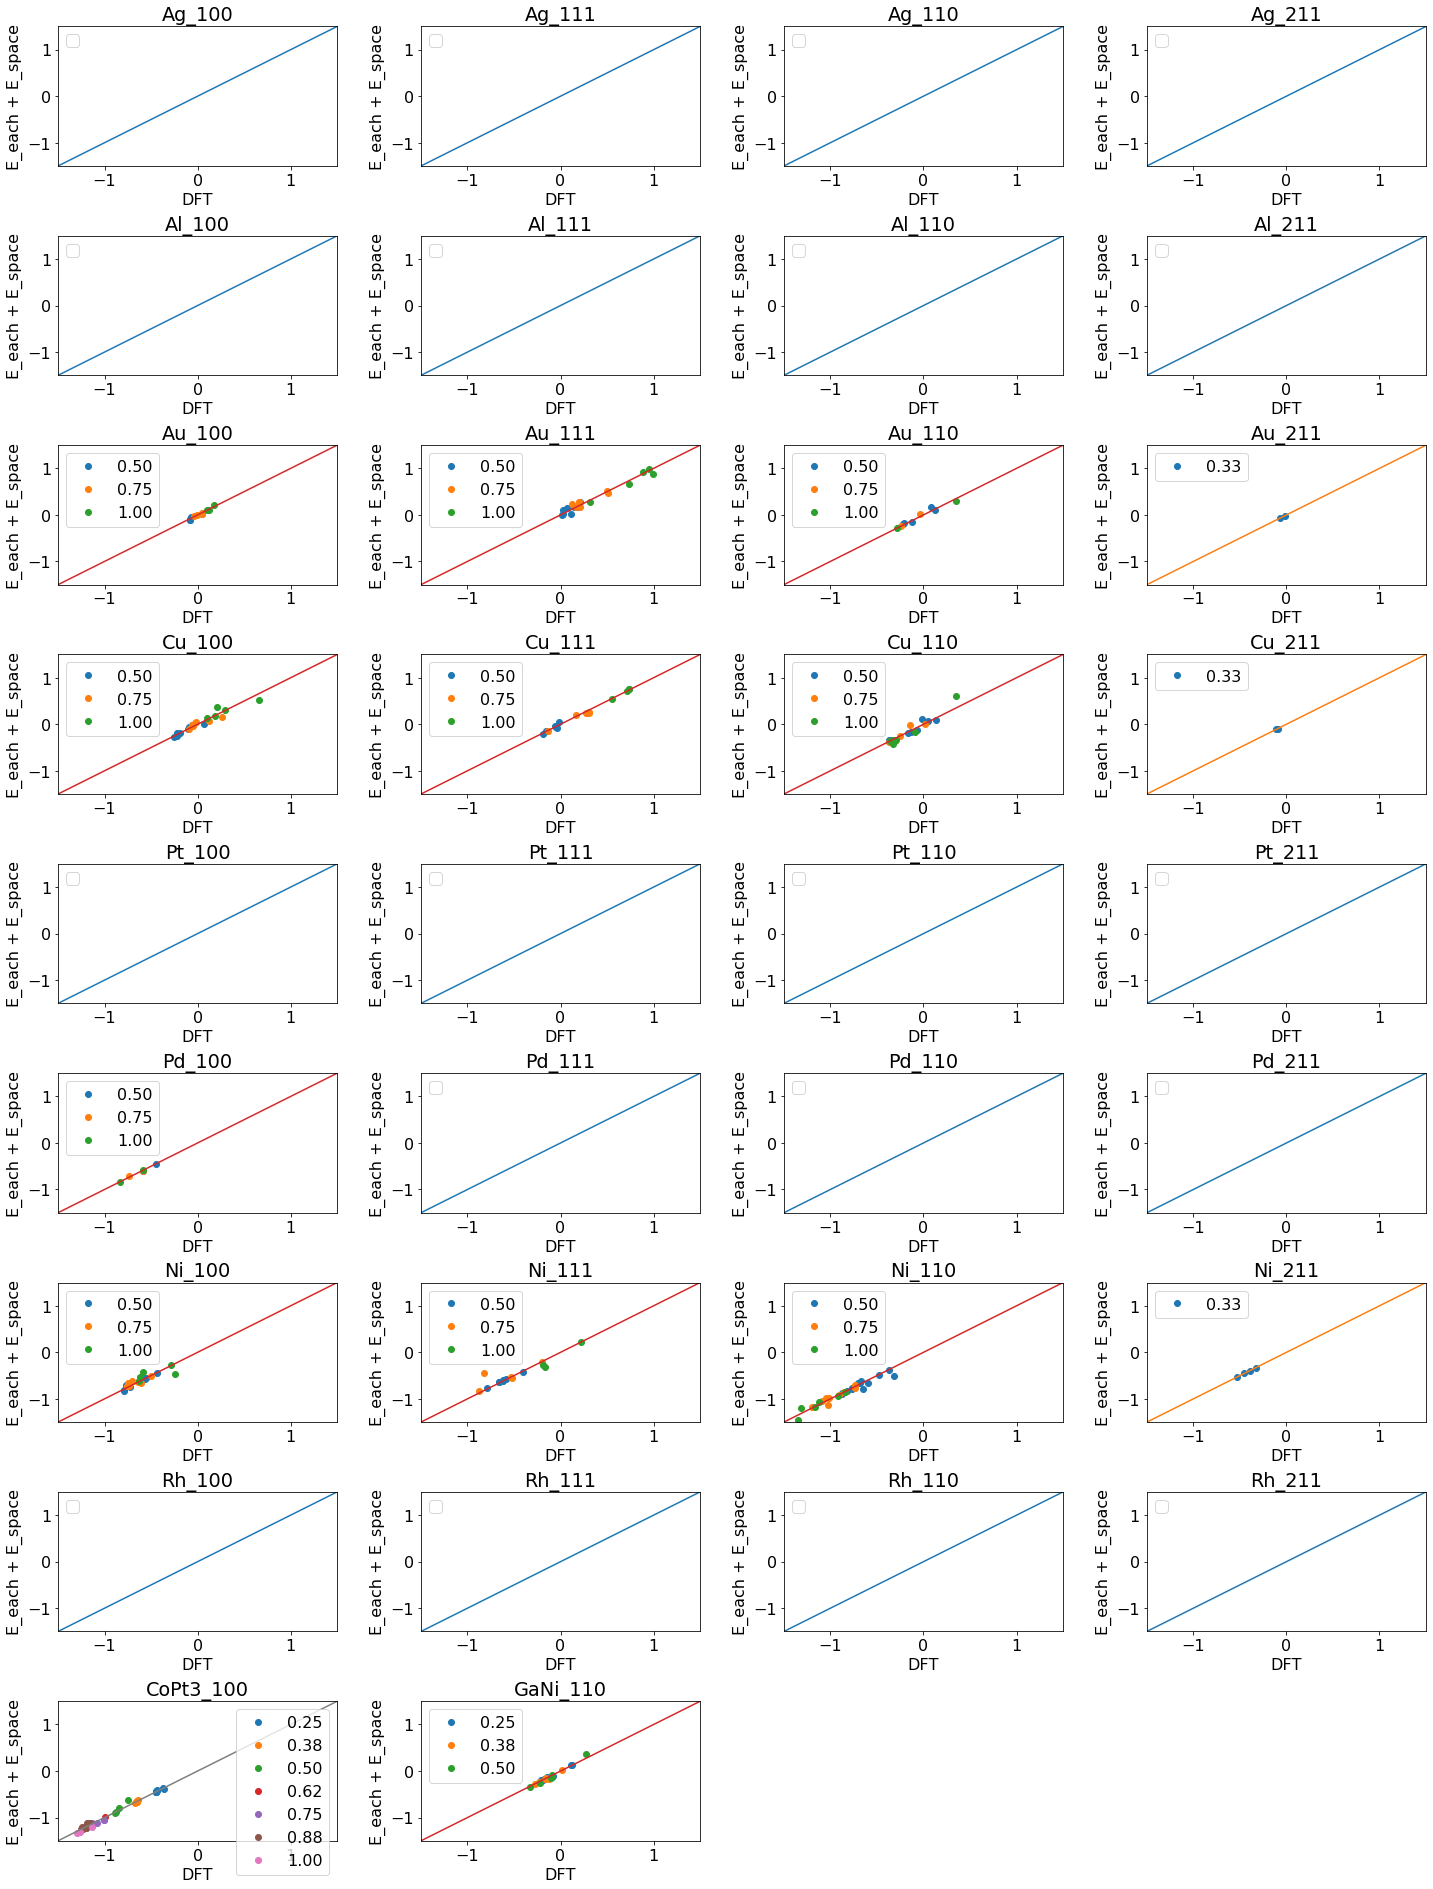

In [11]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        weight2, weight3 = inst[i].fit_weight_from_specific_element_and_face()
        print(weight2, weight3)
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()

22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
22
[0.15108294] [-0.05314476]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
38
[0.03689247] [-0.06293297]
1
[0.0335765] [0.09424938]
1
[0.0335765] [0.09424938]
1
[0.0335765] [0.09424938]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
41
[0.01269623] [0.05736552]
22
[-0.01861888] [0.01834788]

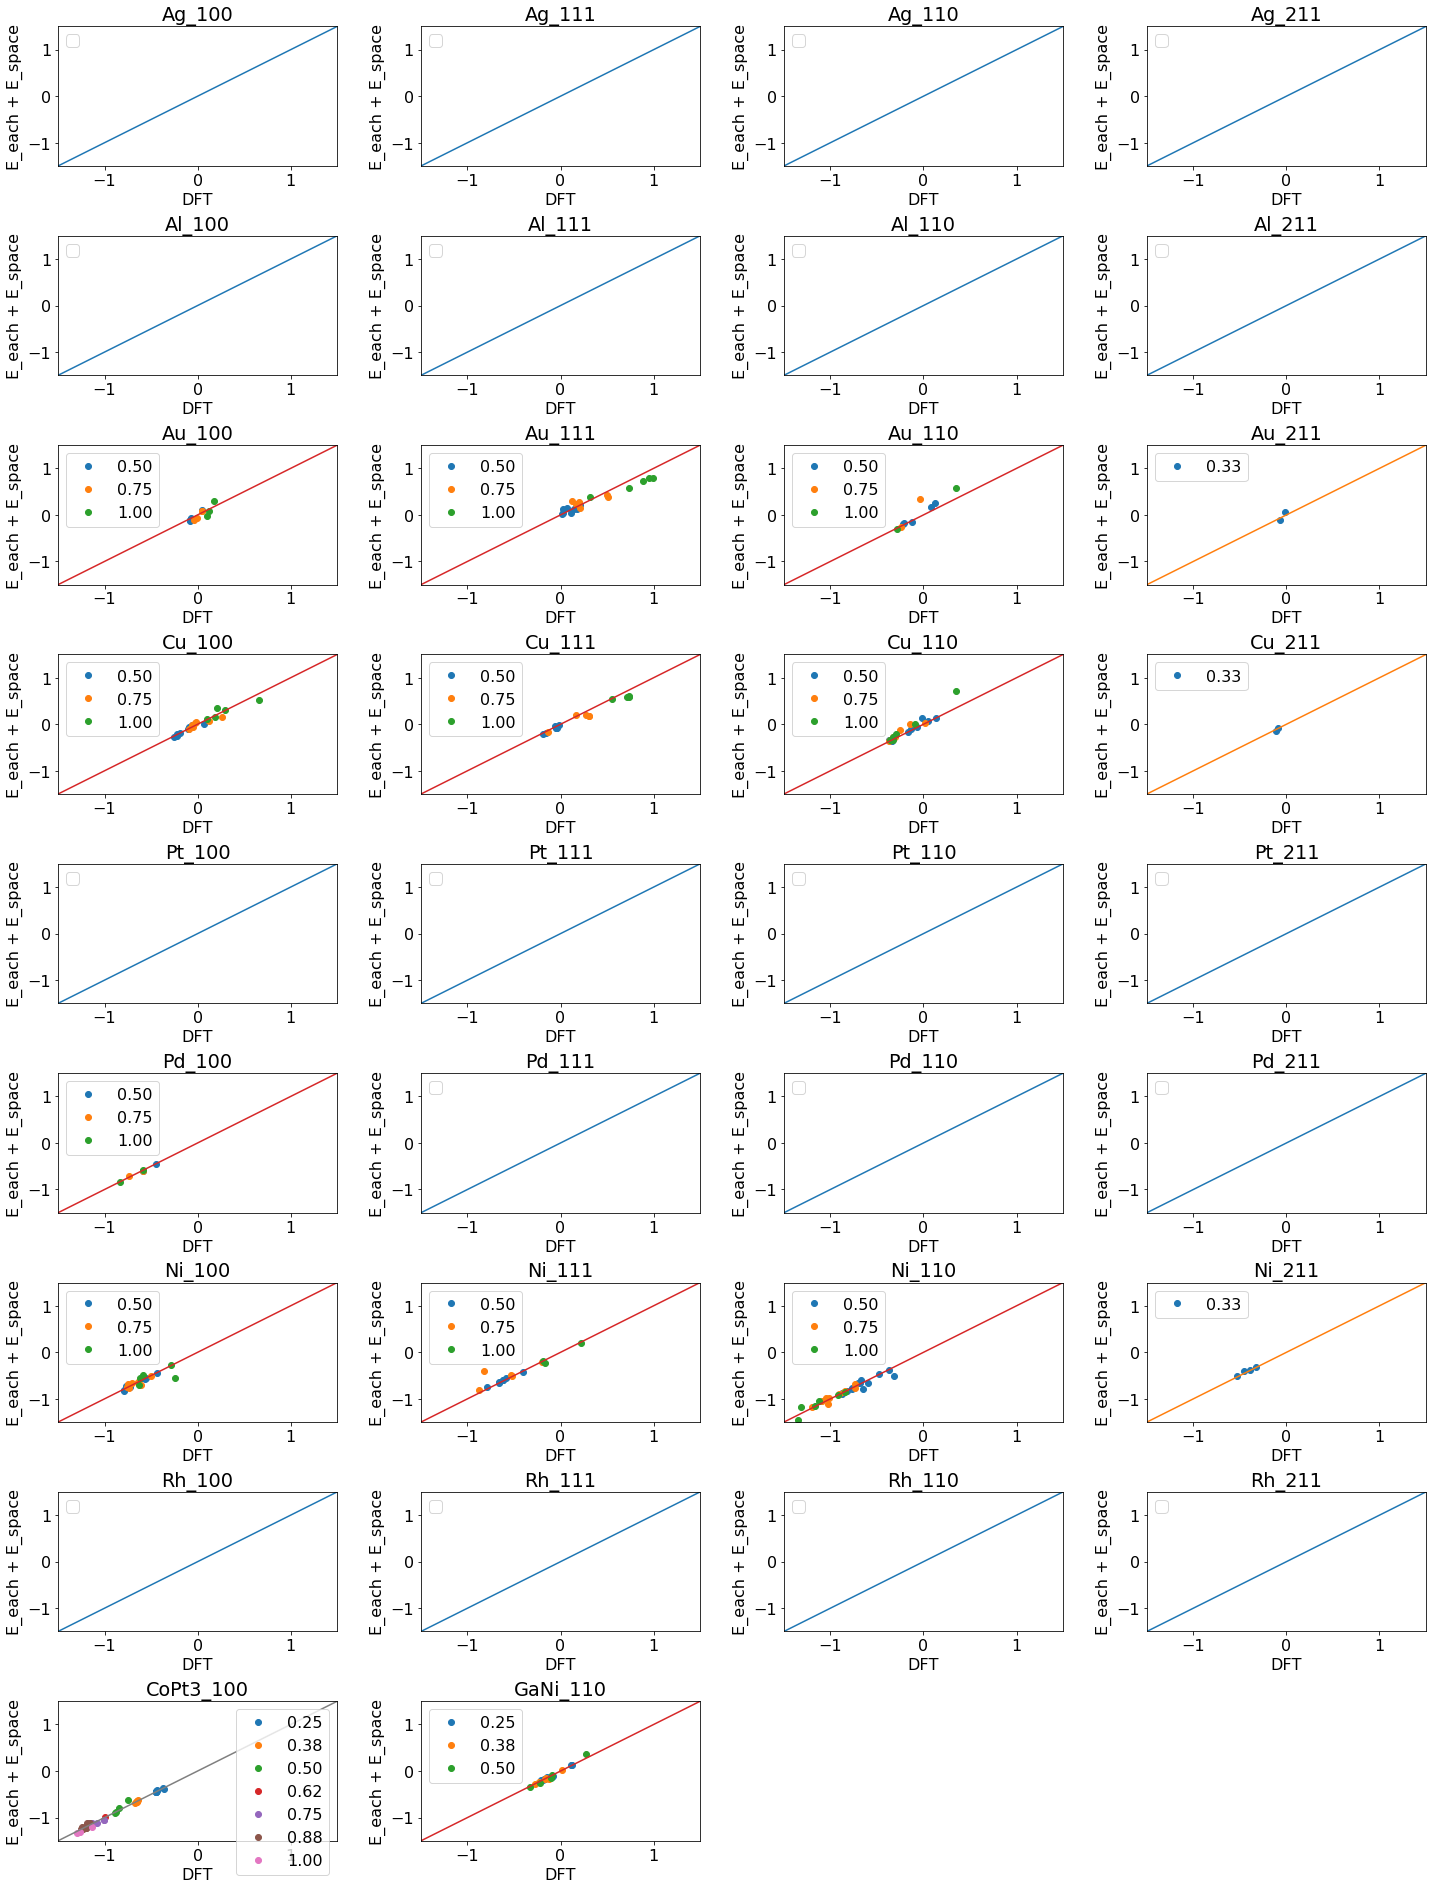

In [12]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(20,30))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(9, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        print
        weight2, weight3 = inst[i].fit_weight_from_specific_element()
        print(weight2, weight3)
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        
        E_residue_pred = data['ads_dist2'] * weight2 + data['ads_dist3'] * weight3
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
# plt.show()